### 과정

전체 회귀 분석 과정
- 데이터 전처리
- 선형 회귀 모델 학습/예측/평가
- 회귀 트리 모델 학습/예측/평가
- 회귀 모델의 예측 결과 혼합을 통한 최종 예측
- 스태킹 앙상블 모델을 통한 회귀 예측

In [115]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from matplotlib import font_manager, rc

path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

# Target 값 : price

In [116]:
car_df_ohe= pd.read_csv('./data/최종 전처리.csv')
car_df_ohe.head()

,km,year,accident,price,wd,trim,brand_BMW,brand_기아,brand_랜드로버,brand_르노삼성,...,type_LPG,type_가솔린,type_디젤,type_바이퓨얼,type_전기,type_하이브리드,color_검정색,color_기타,color_회색,color_흰색
0,74482,5,3,7.616284,0,3,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,148637,6,3,7.496097,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,101095,7,3,7.300473,0,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,191227,6,3,6.836259,0,2,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,150702,6,3,6.907755,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


### 선형 회귀 모델의 학습/예측/평가

LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델 만들기

**RMSE 평가 함수 생성**

In [117]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models :
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [118]:
## 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 타깃과 피처
y_target = car_df_ohe['price']
X_features = car_df_ohe.drop('price',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

**모델 학습/예측/평가**

In [119]:
# 일반 선형 회귀
lr_reg = LinearRegression() 
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)


Lasso()

In [120]:
models= [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) #학습된 모델 전달하고
# rmse값 반환

LinearRegression 로그 변환된 RMSE: 0.221
Ridge 로그 변환된 RMSE: 0.221
Lasso 로그 변환된 RMSE: 0.615


[0.22052007030462092, 0.22056335448486378, 0.6151318117051421]

### 결과
- 라쏘회귀가 타 회귀 방식보다 상대적으로 성능이 떨어진다
- 하이퍼 파라미터 튜닝이 필요(alpha 하이퍼파라미티에 대해서 최적화 수행)

**회귀 계수의 시각화**

- 변수가 많으므로 상위10개 하위 10개의 피처명과 회귀계수값을 반환하는 함수를 작성해서 사용

In [85]:
def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

In [87]:
# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

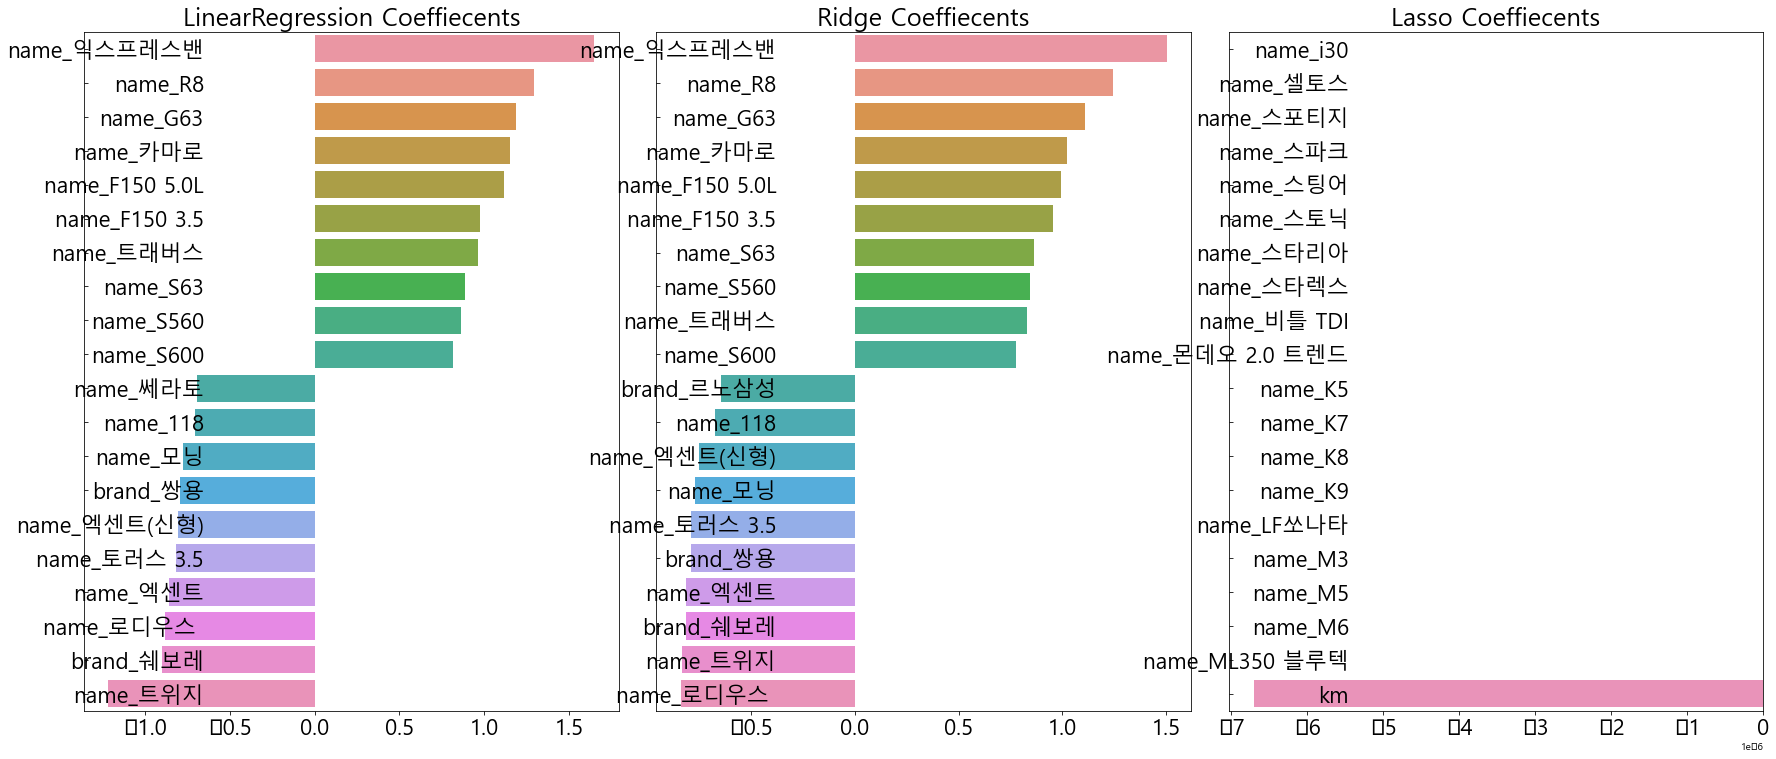

In [88]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

**5 폴드 교차검증으로 모델별로 RMSE와 평균 RMSE 출력**
- 함수 생성

In [89]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))        

In [90]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.409 0.645 0.231 0.21  0.208]
LinearRegression CV 평균 RMSE 값: 0.341

Ridge CV RMSE 값 리스트: [0.41  0.644 0.231 0.211 0.208]
Ridge CV 평균 RMSE 값: 0.341

Lasso CV RMSE 값 리스트: [0.52  0.743 0.645 0.587 0.569]
Lasso CV 평균 RMSE 값: 0.613


### 결과
- 5개 폴드 세트로 학습한 후 평가해도
    - 여전히 라쏘 모델이 다른 회귀 모델에 비해 성능이 떨어짐

**리지/라쏘 모델에 대해 alpha 하이퍼파라미터 튜닝 후 재학습/예측/평가**

In [91]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [100]:
ridge_params = {'alpha' : [0.005,0.01,0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1, 1.5]}

In [101]:
best_ridge = get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.3793, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.3801, 최적 alpha:{'alpha': 0.001}


### 결과
- 릿지 모델 : alpha가 0.1에서 최적 평균 RMSE 가 0.3793
- 라쏘 모델 : alpha가 0.001에서 최적 평균 RMSE가 0.3801

**분할된 트레인 테스트 데이터를 이용해 학습 후 평가**

In [156]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [157]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.221
Ridge 로그 변환된 RMSE: 0.223
Lasso 로그 변환된 RMSE: 0.273


[0.22052007030462092, 0.22268219664136657, 0.27291876678258126]

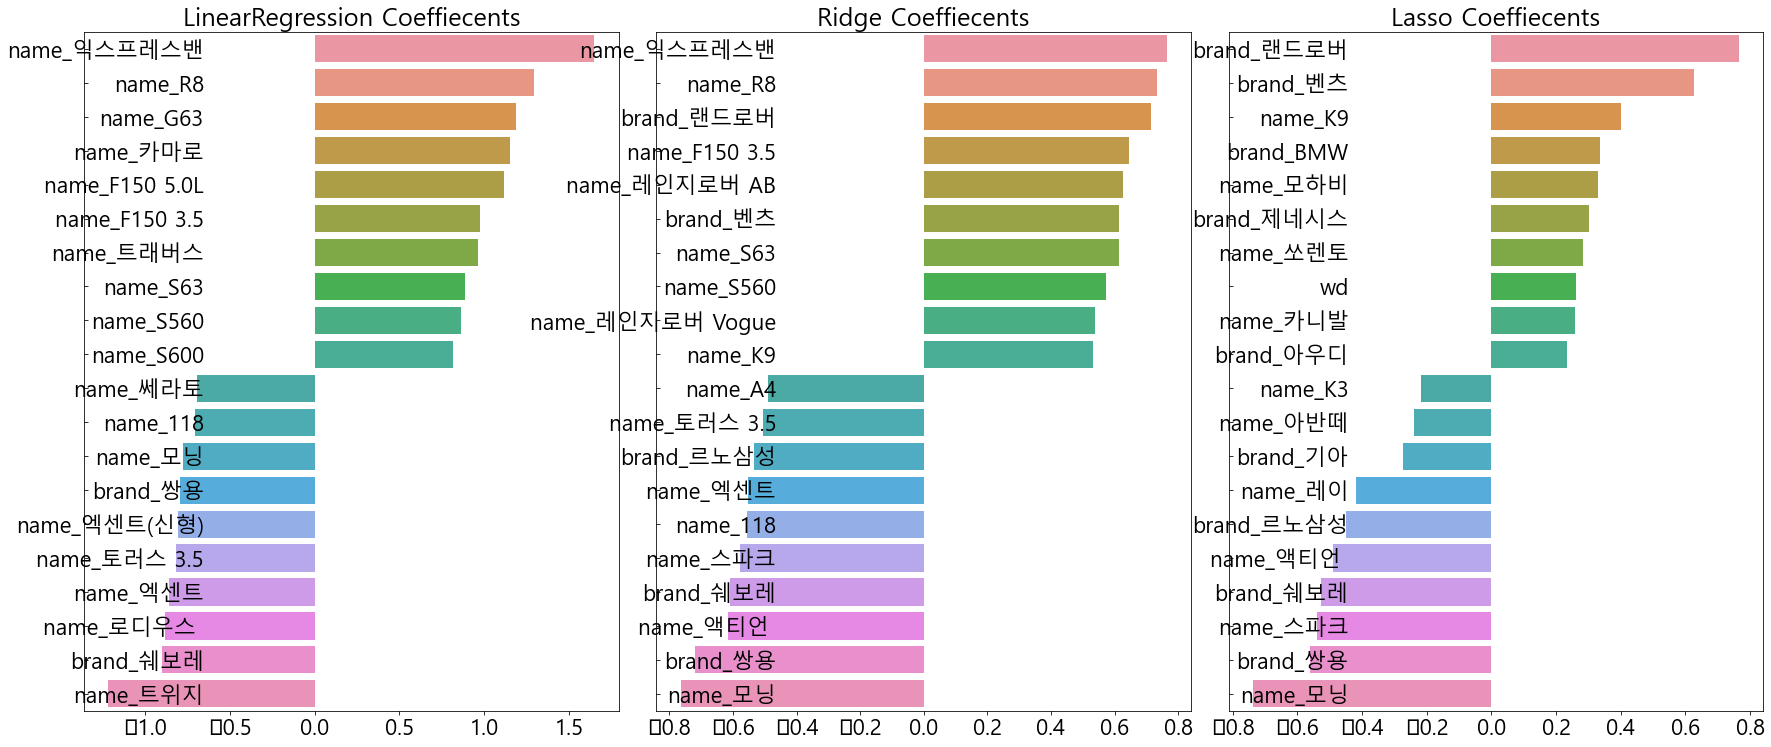

In [104]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 회귀 트리 학습/예측/평가 

** XGBoost와 LightGBM 학습/예측/평가 **

회귀 트리
- 회귀 함수를 기반으로 하지 않고
- 트리를 기반으로 하는 회귀 방식
- 분류 트리와 유사하지만
- 리트 노드에서 예측 결정값을 만드는 과정에 차이가 있음
- 분류 트리 :  특정 클래스 레이블을 결정
- 회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산

CART(Classification And Regression Trees) 기반 알고리즘
- 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 트리 기반 알고리즘은
- 분류뿐만 아니라 회귀도 가능

In [105]:
# XGBoost와 LightGBM 모두 수행 시간이 오래 걸릴 수 있는 관계로
# 하이퍼 파라미터 설정을 미리 적용한 상태로
# 5 폴드 세트에 대한 평균 RMSE 값 추출

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                      colsample_bytree=0.5, subsample=0.8)

best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.327, 최적 alpha:{'n_estimators': 1000}


In [106]:
# 이번에는 LightGBM 회귀 트리 적용

from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.3536, 최적 alpha:{'n_estimators': 1000}


**트리 회귀 모델의 피처 중요도 시각화**

In [107]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

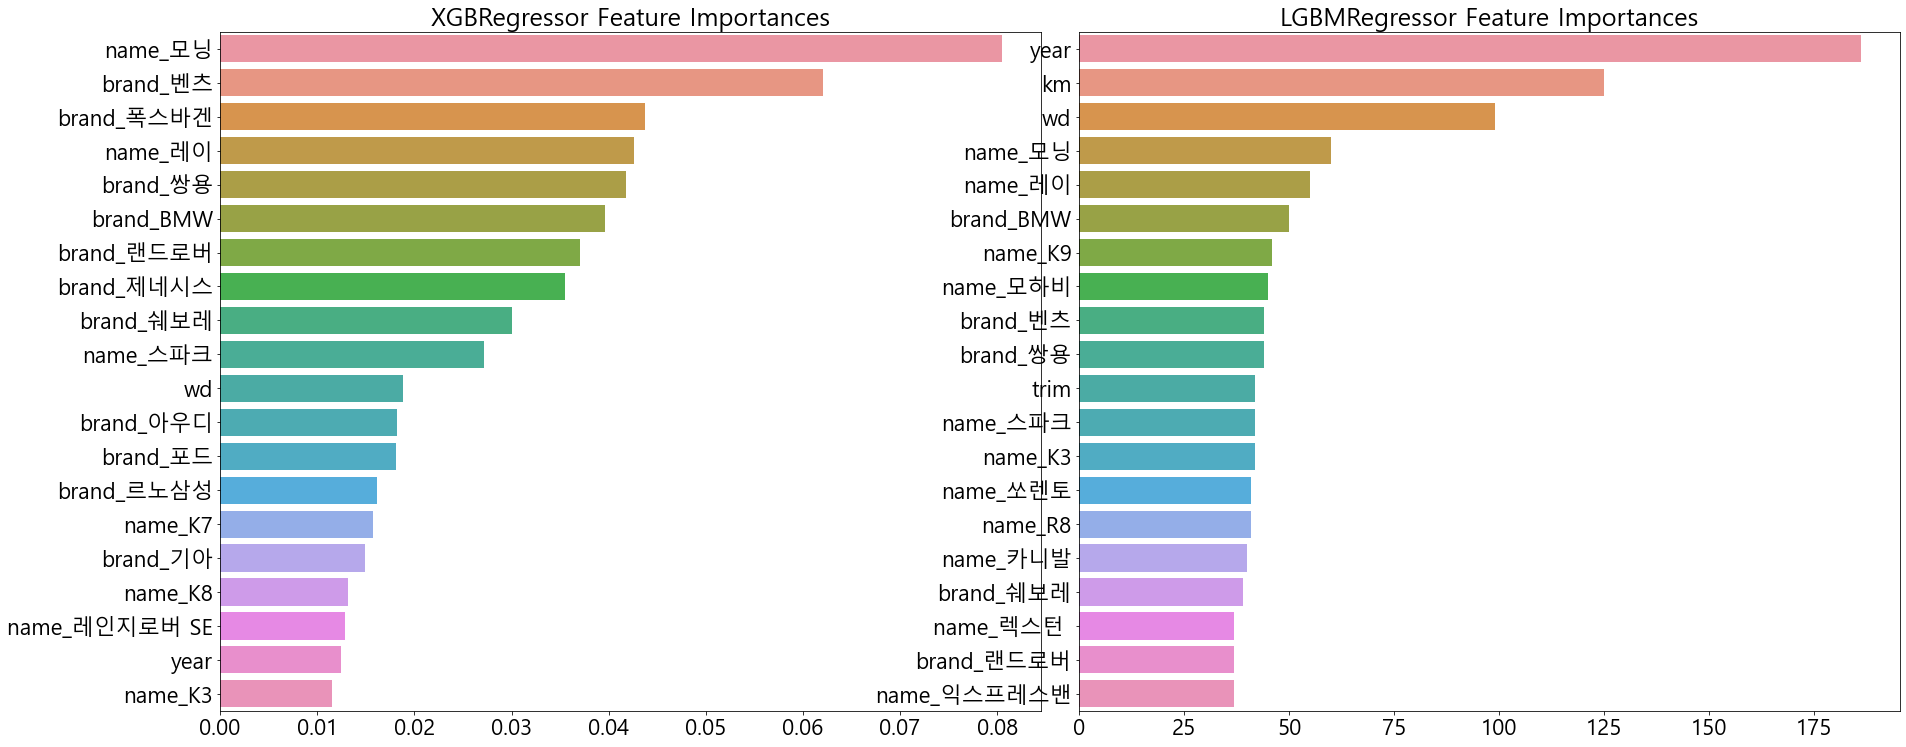

In [108]:
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

- 개별 회귀 모델의 예측 결과값을 혼합해서 이를 기반으로 최종 회귀값 예측

- ex. 
    - A모델,B모델
    - A모델의 예측값의 40%, B모델의 예측값의 60%를 더해서 최종 회귀값으로 예측
    - A[100, 80, 60], B[120, 80, 50]
    - [100 * 0.4 + 120 * 0.6, 80 * 0.4 + 80 * 0.6, 60 * .4 + 50 * 0.6]

In [109]:
# 최종 혼합 모델과 개별 모델의 RMSE 값 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

In [153]:
# 개별 모델 학습
ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

In [158]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.6 * ridge_pred + 0.4*lasso_pred

In [159]:
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.23953756365862847
Ridge 모델의 RMSE: 0.22712996557540965
Lasso 모델의 RMSE: 0.27291876678258126


### 결과
- 최종 예측 결과를 혼합한 RMSE가 개별 모델보다 성능면에서 약간 개선됨
- 두 모델의 예측을 모두 반영하되 성능이 조금 좋은 쪽에 가중치를 두고 반형한 결고

#### 이번에는 XGBoost와 LightGBM 혼합 (각 50%)

In [139]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)



In [140]:
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.19818112368471894
XGBM 모델의 RMSE: 0.17896780105342652
LGBM 모델의 RMSE: 0.2287683592543816


### 결과
- 많은 차이는 아니지만 혼합 예측 결과가 개별모델 RMSE보다 아주 약간 향상됨

## 스태킹 모델을 통한 회귀 예측

**스태킹모델은 회귀에도 적용 가능한 앙상블 모델**

#### 스태킹(stacking)  

- 개별적인 여러 알고리즘(모델)을 서로 결합해 예측 결과를 도출함 
    - 배깅 및 부스팅 방식과 동일
    
- 배깅 및 부스팅과의 차이점
    - 개별알고리즘으로 예측한 데이터를 기반으로
    - 다시 예측을 수행

#### 수행순서
1. 개별 알고리즘의 예측 결과 데이터 세트를 생성
2. 1번에서 생성된 데이터 세트를 메타 데이터 세트로 만든다
3. 2번에서 생성된 데이터 세트를 별도의 ML 알고리즘(개발자가 선택)으로 최종 학습을 수행하고
4. 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식

#### 메타모델 
- 개별 모델을 메타모델이라고 함
- 메타모델의 예측 결과가 최종 모델의 데이터세트로 활용 됨

#### 스태킹 모델 구현 방식
- 두 종류의 모델 필요
1. 개별적인 기반모델
2. 개별 기반 모델의 예측데이터를 학습데이터로 사용하는 최종 모델

#### 스태킹 모델의 핵심 
- 여러 개별 모델의 예측 데이터를
- 각각 스태킹 형태로 결합해 
- **최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것**
    - 사용자 정의 함수로 구현
    - get_stacking_base_datasets() 함수


In [121]:
from sklearn.model_selection import KFold #트레인데이터를 학습/검증 세트로 분리하기 위해 필요
from sklearn.metrics import mean_absolute_error

In [122]:
# 개별 기반 모델(1개의 모델) 최종 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds) :
    # 지정된 n_folds 값으로 KFold 객체 생성
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)
    
    # 최종모델이 사용할 학습 데이터를 위한 초기 구성 - 넘파이배열로 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
       #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 테스트 데이터를 폴드세트의 평균으로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean    
    
    

**기반 개별 모델은 리지, 라소, XGBoost, LightGBM 으로 생성**
- 최종 모델을 라소로 생성하여 학습/예측/평가

In [123]:
# 생성한 함수가 ndarray를 인자로 사용하므로 DF를 ndarray로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [124]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [125]:
# 각 개별 모델이 반환한 학습용피처 데이터와 테스트용피터 데이터 세트를 결합해서 최종데이터세트 생성
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

In [126]:
Stack_final_X_train

array([[7.0363111 , 7.75610686, 7.30247593, 7.26914558],
       [7.6132221 , 7.75880802, 7.923985  , 7.88815994],
       [7.79081757, 7.91055907, 7.86465216, 7.7550011 ],
       ...,
       [7.34795271, 7.46518789, 7.37625885, 7.40437949],
       [5.85707162, 7.03408034, 5.80012465, 6.05930439],
       [8.16564878, 7.41190994, 8.22484875, 8.10538875]])

In [129]:
# 최종 모델을 릿지 모델을 적용
meta_model_ridge = Ridge(alpha=20)

In [130]:
meta_model_ridge.fit(Stack_final_X_train,y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.17425653158939053


In [146]:
test=X_features.head()
test

,km,year,accident,wd,trim,brand_BMW,brand_기아,brand_랜드로버,brand_르노삼성,brand_미니,...,type_LPG,type_가솔린,type_디젤,type_바이퓨얼,type_전기,type_하이브리드,color_검정색,color_기타,color_회색,color_흰색
0,74482,5,3,0,3,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,148637,6,3,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,101095,7,3,0,2,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,191227,6,3,0,2,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,150702,6,3,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [172]:
value=xgb_reg.predict(test)
np.expm1(value)

array([2081.6155, 1954.1716, 1486.2728, 1190.2772, 1037.1521],
      dtype=float32)

In [170]:
np.expm1(y_target).head()

0    2030.0
1    1800.0
2    1480.0
3     930.0
4     999.0
Name: price, dtype: float64

In [133]:
# 최종 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.001)

In [134]:
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.17548532597408648


In [135]:
# 최종 모델은 XGBoost, LightGBM 모델을 적용
meta_model_xgb_reg = xgb_reg

In [136]:
meta_model_xgb_reg.fit(Stack_final_X_train,y_train)
final = meta_model_xgb_reg.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.1756785709751354


In [137]:
# 최종 모델은 라쏘 모델을 적용
meta_model_lgbm_reg = lgbm_reg

In [138]:
meta_model_lgbm_reg.fit(Stack_final_X_train,y_train)
final = meta_model_lgbm_reg.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse=np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.18885973981486073


### 결과
- 최종적으로 스태킹 회귀 모델을 적용한 결과 
- 테스트 데이터세트에서 RMSE가 0.1754로 위에서 진행한 모델 포함 가장  좋은 성능평가를 보여줌

#### 아무것도 처리 안한것:
LinearRegression 로그 변환된 RMSE: 0.221
Ridge 로그 변환된 RMSE: 0.221
Lasso 로그 변환된 RMSE: 0.615
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.327
LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.3536

#### 5폴드 교차검증한것:
LinearRegression CV 평균 RMSE 값: 0.341
Ridge CV 평균 RMSE 값: 0.341
Lasso CV 평균 RMSE 값: 0.613

#### 최적의 하이퍼파라미터 적용한것
LinearRegression 로그 변환된 RMSE: 0.221
Ridge 로그 변환된 RMSE: 0.227
Lasso 로그 변환된 RMSE: 0.273

#### 혼합한것
릿지 60%, 라쏘 40% 혼합 모델의 RMSE: 0.23953756365862847
XGBM 50%, LGBM 50% 혼합 모델의 RMSE: 0.19818112368471894

#### 스태킹 모델 적용한것
릿지 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.17425653158939053
라쏘 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.17548532597408648
XGB 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.1756785709751354
LGBM 적용 스태킹 회귀 모델의 최종 RMSE 값은: 0.18885973981486073